In [1]:
# !git clone https://github.com/AxelThevenot/Python_Benchmark_Test_Optimization_Function_Single_Objective.git
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/src .
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/pybenchfunction/ .
# !ls Python_Benchmark_Test_Optimization_Function_Single_Objective/

In [2]:
import torch
from tqdm.notebook import tqdm
import numpy as np

import pybenchfunction as bench
from src.stoch_functions import LevyN13_i, PermDBeta_i,  Rastrigin_i, RosenBrock_i
%matplotlib inline

In [3]:
from src.algorithms import *

In [4]:
from src.plotting import plot_function_values, plot_level_set_results

In [5]:
import time

def run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = None, adam_step = 0.01, running_newton = True):
    t0 = time.perf_counter()
    SP2plus_x_list, SP2plus_fval  =run_SP2plus(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize)
    SP2plus_time = time.perf_counter() -t0
    t0 = time.perf_counter()
    SP2_x_list, SP2_fval  =run_SP2(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize)
    SP2_time = time.perf_counter() -t0
    t0 = time.perf_counter()
    SGD_x_list, SGD_fval  =run_SGD(fi, epochs=epochs, x0 = x0,d=d, lr=sgd_step)
    SGD_time = time.perf_counter() -t0
    t0 = time.perf_counter()
    if running_newton:
        newt_x_list, newt_fval=run_newton_stoch(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize)
    else:
        newt_x_list =0; newt_fval =0
    newt_time = time.perf_counter() -t0
    t0 = time.perf_counter()
    SP_x_list, SP_fval=run_SP2plus(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize, nosp1=False)
    SP_time = time.perf_counter() -t0
    t0 = time.perf_counter()
    Adam_x_list, Adam_fval=adam(fi, epochs=epochs, x0 = x0, d=d, lr=adam_step )
    Adam_time = time.perf_counter() -t0
    results = {"SP2plus": (SP2plus_time, SP2plus_fval, SP2plus_x_list), 
                "SP2": (SP2_time, SP2_fval, SP2_x_list), 
                "SGD": (SGD_time, SGD_fval, SGD_x_list), 
                "SP": (SP_time, SP_fval, SP_x_list), 
                "Adam": (Adam_time, Adam_fval, Adam_x_list), 
                "Newton": (newt_time, newt_fval, newt_x_list),   }
    return results #fvals, times, xvals
    
def run_plot_all(fi,ffull, epochs, stepsize,x0,d, sgd_step = None, adam_step = 0.01):
    if sgd_step is None:
        sgd_step = stepsize
    if adam_step is None:
        adam_step = stepsize
    results = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step, adam_step = adam_step)
    plot_function_values(ffull, results)
    plot_level_set_results(ffull, results ) 

In [6]:
# Global stepsize for methods except SGD (which required tuning)
stepsize= 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

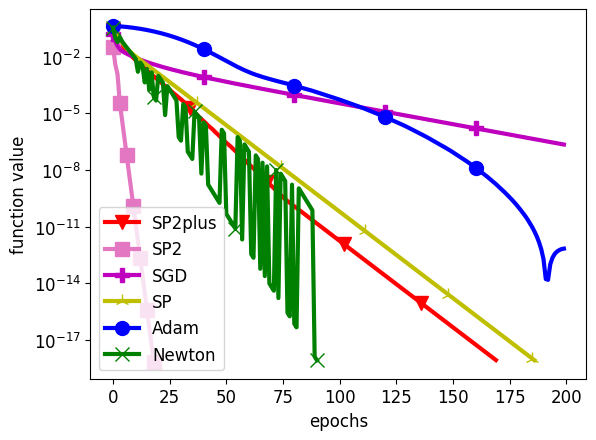

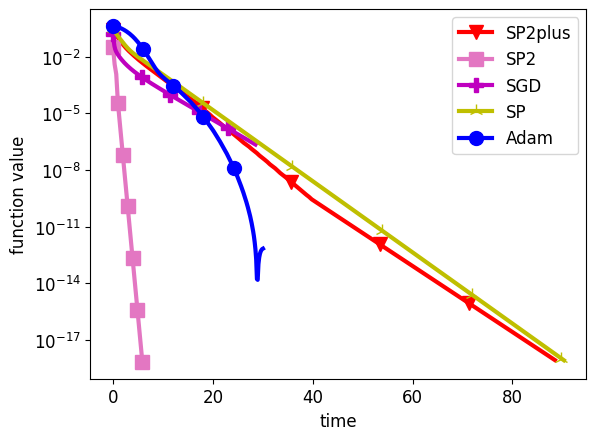

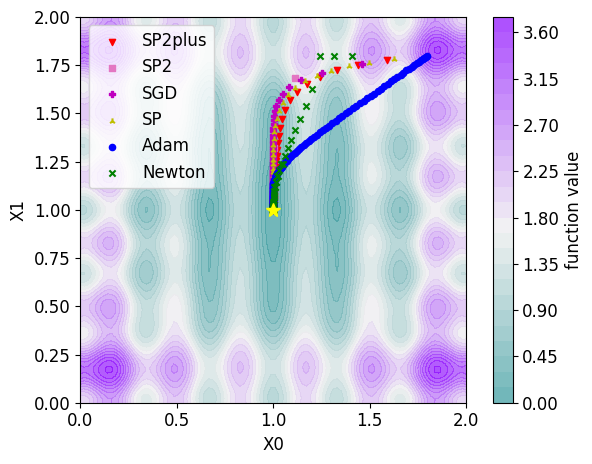

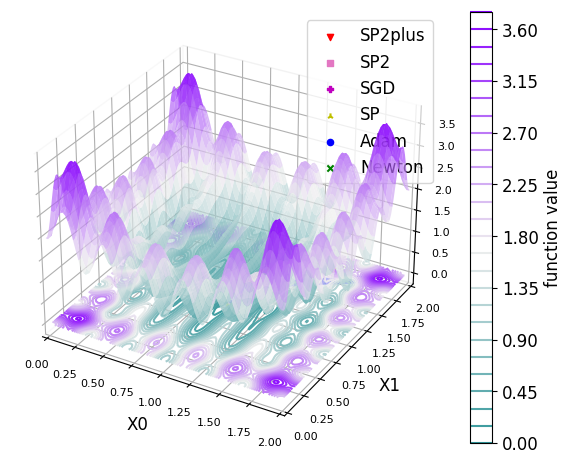

In [7]:
d=2
epochs = 200
x0 = torch.ones(d, requires_grad=True).double() *1.8
fi = LevyN13_i
ffull  = bench.function.LevyN13(d)
run_plot_all(fi,ffull, epochs, stepsize,x0,d, sgd_step = stepsize, adam_step=0.05) #, 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

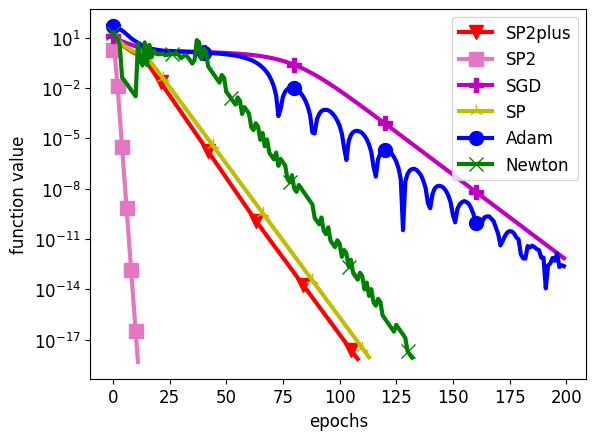

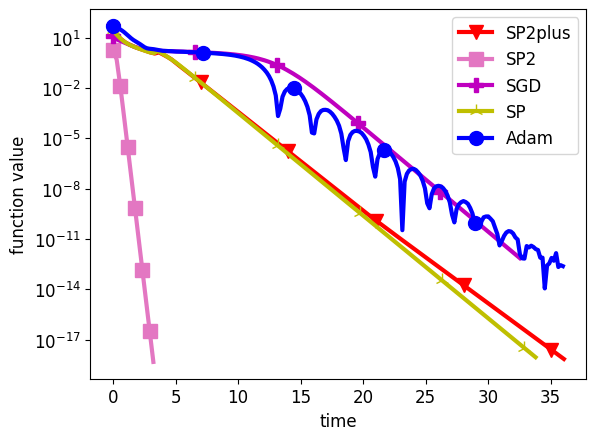

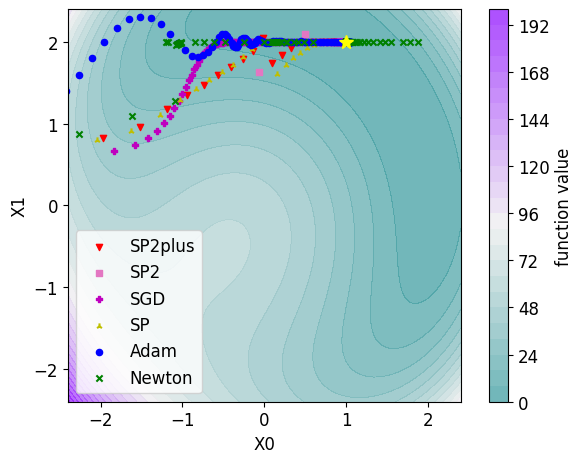

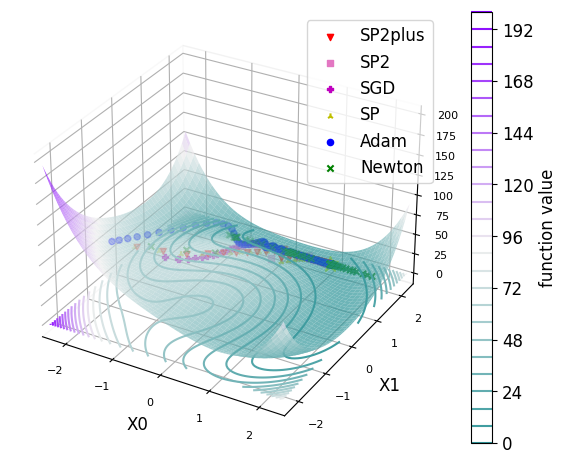

In [8]:

d=2
epochs = 200
x0 = -2*torch.randn(d, requires_grad=True).double()
fi = PermDBeta_i
ffull  = bench.function.PermDBeta(d)
run_plot_all(fi,ffull, epochs, stepsize,x0,d, sgd_step = 0.01, adam_step=1.0)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

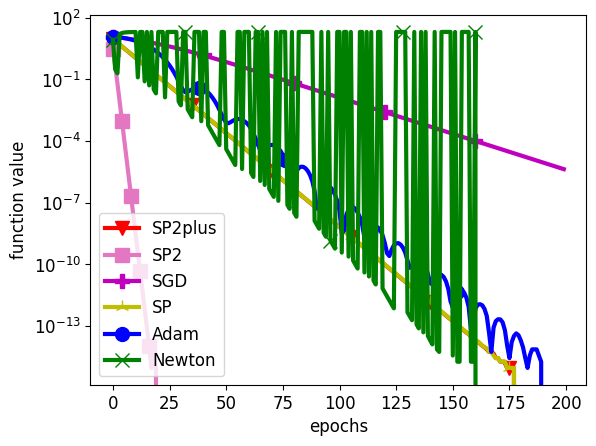

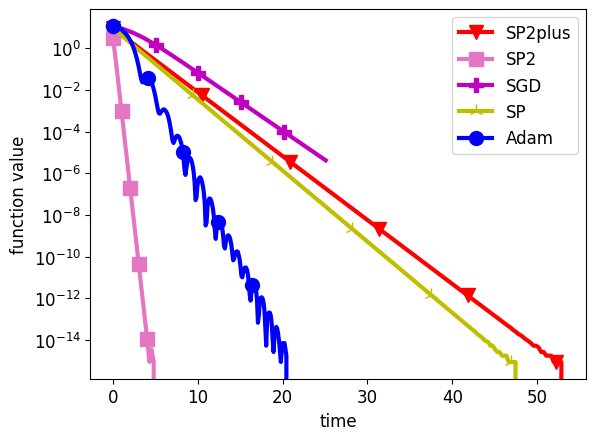

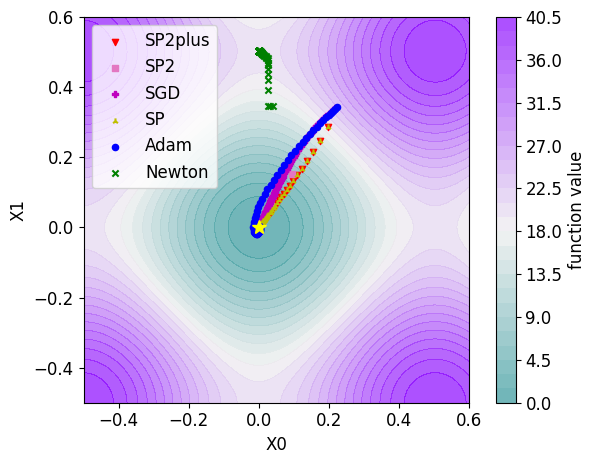

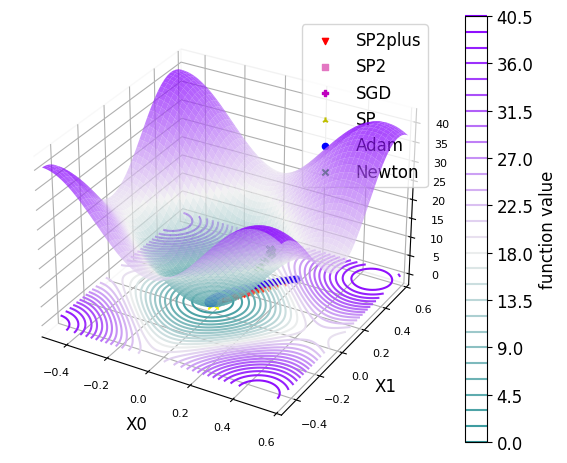

In [9]:
d=2
epochs = 200
x0 = torch.rand(d, requires_grad=True).double() *0.45
fi = Rastrigin_i
ffull  = bench.function.Rastrigin(d)
run_plot_all(fi,ffull, epochs, stepsize,x0,d, sgd_step = 0.0001, adam_step=0.05)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

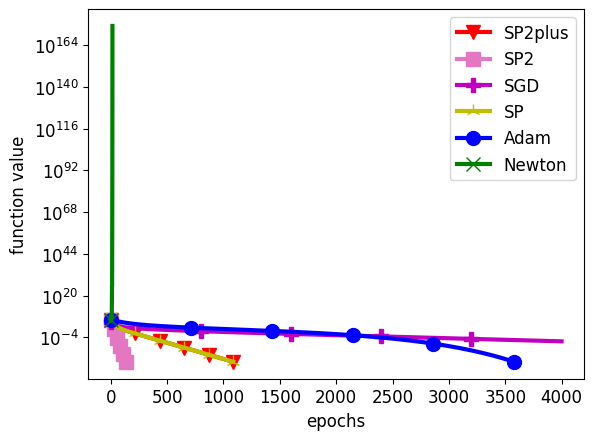

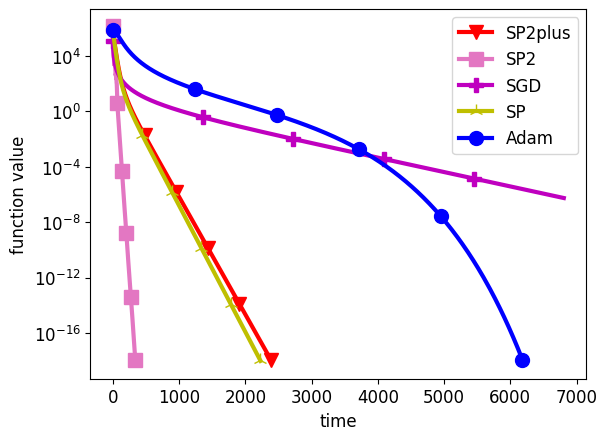

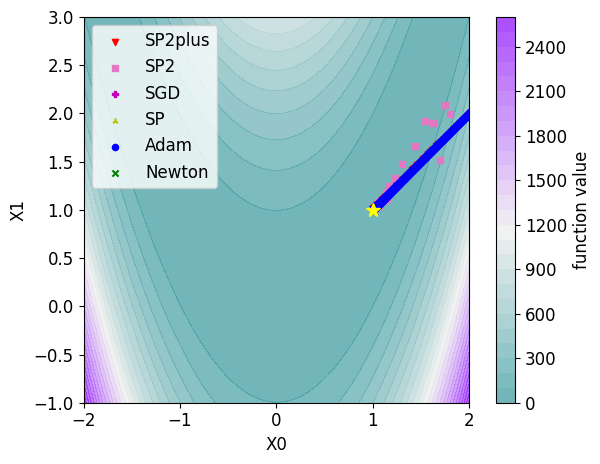

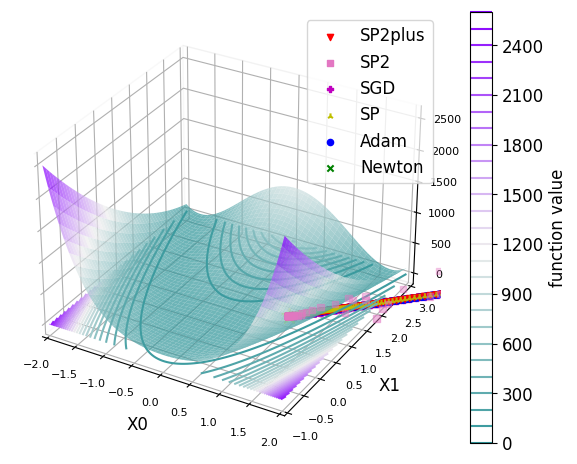

In [10]:
d=2
epochs = 4000
x0 = torch.ones(d, requires_grad=True).double()*10
fi = RosenBrock_i
ffull  = bench.function.Rosenbrock(d)
rosenstep = stepsize #/3
run_plot_all(fi,ffull, epochs, rosenstep, x0,d, sgd_step = 0.00001, adam_step=stepsize)


In [11]:
d = 10
stepsize = 0.005
sgd_step = 0.0000000001
adam_step = 0.5  # 0.1
epochs = 100 # 4000
x0 = -2*torch.randn(d, requires_grad=True).double()
fi = PermDBeta_i
ffull  = bench.function.PermDBeta(d)
results = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step, adam_step = adam_step, running_newton = False)
plot_function_values(ffull, results, add_caption = str(d))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
d =100
stepsize = 0.5
sgd_step = 0.005
adam_step = 0.001 # 0.001
epochs = 1000 # 1000
x0 = torch.rand(d, requires_grad=True).double() *0.45
fi = Rastrigin_i
ffull  = bench.function.Rastrigin(d)
results = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step, adam_step = adam_step, running_newton = False)
plot_function_values(ffull, results, add_caption = str(d))

In [ ]:
d= 100
stepsize = 0.1
sgd_step = 0.00001
adam_step = 0.05  #0.05
epochs = 4000 # 4000
x0 = torch.ones(d, requires_grad=True).double()*10
fi = RosenBrock_i
ffull  = bench.function.Rosenbrock(d)
results = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step, adam_step = adam_step, running_newton = False)
plot_function_values(ffull, results, add_caption = str(d))